In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from pathlib import Path
from PIL import Image

pd.set_option('display.max_columns', 200)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(12, 6)
plt.rcParams['font.size']=10

In [21]:
# Initial configurations
DATASET_PATH='../../data/food-101/food-101'
OUTPUT_PATH='../../data/food-101/food-101-processed'

TARGET_SIZE=(224, 224)

TRAIN_RATIO=0.7
VAL_RATIO=0.15
TEST_RATIO=0.15

dataset_path=Path(DATASET_PATH)
images_path=dataset_path/'images'
meta_path=dataset_path/'meta'

Sampling classes: 100%|██████████| 20/20 [00:00<00:00, 210.39it/s]


Image statistics (sample of 100)
Width: 
Max: 512 | Min: 289 | Mean: 481.79
Height: 
Max: 512 | Min: 288 | Mean: 477.56


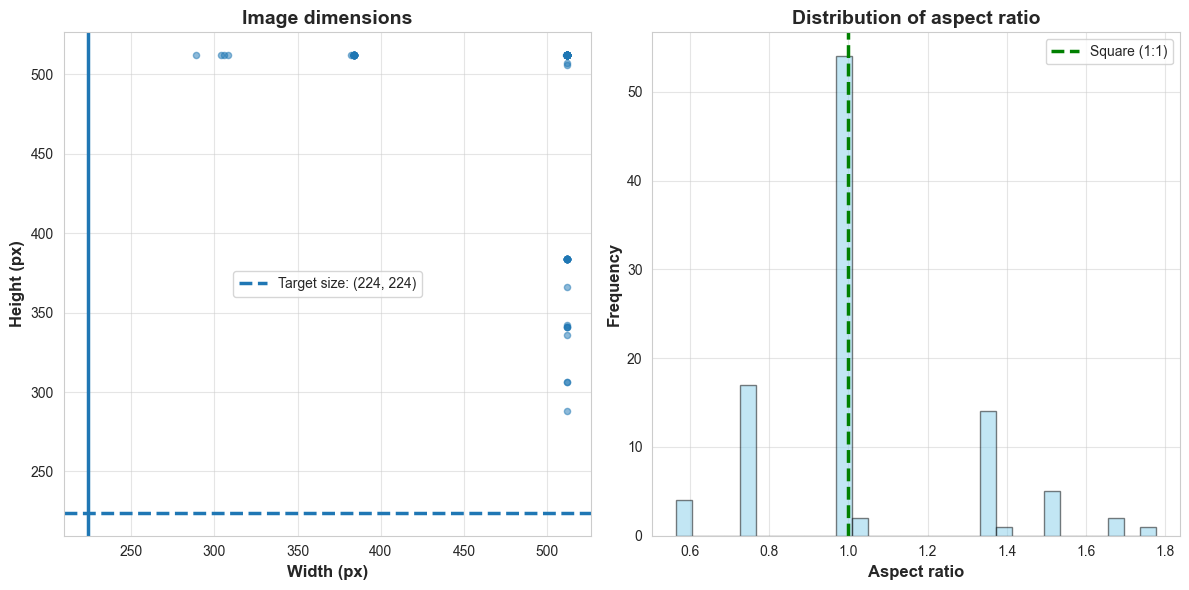

In [30]:
class_folders=sorted([d for d in images_path.iterdir() if d.is_dir()])
dimensions=[]
aspect_ratio=[]

for class_folder in tqdm.tqdm(class_folders[:20], desc='Sampling classes'):
    images=list(class_folder.glob('*jpg'))[:5]
    
    for img_path in images:
        try: 
            with Image.open(img_path) as img: 
                width, height=img.size
                dimensions.append((width, height))
                aspect_ratio.append(width / height)
        except:
            pass

widths=[d[0] for d in dimensions]
heights=[d[1] for d in dimensions]

print(f'Image statistics (sample of {len(dimensions)})')
print(f'Width: \nMax: {max(widths)} | Min: {min(widths)} | Mean: {np.mean(widths):.2f}')
print(f'Height: \nMax: {max(heights)} | Min: {min(heights)} | Mean: {np.mean(heights):.2f}')


fig, ax=plt.subplots(1, 2, figsize=(12, 6))

ax[0].scatter(widths, heights, alpha=0.5, s=20)
ax[0].axhline(TARGET_SIZE[0], linestyle='--', linewidth=2.5, label=f'Target size: {TARGET_SIZE}')
ax[0].axvline(TARGET_SIZE[1], linestyle='-', linewidth=2.5)
ax[0].set_xlabel('Width (px)', fontsize=12, fontweight='bold')
ax[0].set_ylabel('Height (px)', fontsize=12, fontweight='bold')
ax[0].set_title('Image dimensions', fontsize=14, fontweight='bold')
ax[0].legend()
ax[0].grid(alpha=0.5)

ax[1].hist(aspect_ratio, bins=30, color='skyblue', edgecolor='black', alpha=0.5)
ax[1].axvline(1, color='green', linestyle='--', linewidth=2.5, label='Square (1:1)') 
ax[1].set_xlabel('Aspect ratio', fontsize=12, fontweight='bold')
ax[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax[1].set_title('Distribution of aspect ratio', fontsize=14, fontweight='bold')
ax[1].legend()
ax[1].grid(alpha=0.5)

plt.tight_layout()
plt.show()

In [ ]:
# Resize Img